In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 10]

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import minerl
from tqdm import tqdm

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utilities import flatten, unflatten, to_batch_shape, to_torch_channels

import autoencoder
from AdvancedAutoencoder import AdvancedAutoencoder
from networks import WMAutoencoder, WM_VAE, VisionEncoder, VisionDecoder, VAELatent
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from dataset_preprocessing import MineRlSequenceDataset
import torch.distributions as D

/home/marthinwurer/.pyenv/versions/3.9.6/envs/minerl/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [4]:
# BATCH_SIZE = 512
# BATCH_SIZE = 256
# BATCH_SIZE = 128
# BATCH_SIZE = 64
# BATCH_SIZE = 32
BATCH_SIZE = 8
LEARNING_RATE = 0.0001
EPOCHS = 30
MOMENTUM = 0.9
# IN_POWER = 8
# IN_POWER = 6
in_dim = 64

In [5]:
def gen_data(n=512):
    y = np.linspace(-1, 1, n)
    x = 7 * np.sin(5 * y) + 0.5 * y + 0.5 * np.random.randn(*y.shape)
    return x[:,np.newaxis], y[:,np.newaxis]

In [6]:
class MyMDN(nn.Module):
    def __init__(self, input_size, output_size, num_gaussians):
        super().__init__()
        self.output_size = output_size
        self.input_size = input_size
        self.num_gaussians = num_gaussians
        num_outs = output_size * num_gaussians
        self.pi = nn.Sequential(nn.Linear(input_size, num_outs), nn.Softplus())
        self.mu = nn.Linear(input_size, num_outs)
        self.sigma = nn.Sequential(nn.Linear(input_size, num_outs), nn.Softplus())
        
    def forward(self, input):
        pi = self.pi(input).view(input.shape[0], self.output_size, self.num_gaussians)
        mu = self.mu(input).view(input.shape[0], self.output_size, self.num_gaussians)
        sigma = self.sigma(input).view(input.shape[0], self.output_size, self.num_gaussians)
        return pi, sigma, mu

In [7]:
def mdn_distribution(pi, sigma, mu):
    mix = D.Categorical(pi)
    comp = D.Normal(mu, sigma)

    gm = D.MixtureSameFamily(mix, comp)
    return gm

In [8]:
def mdn_gnll_loss(pi, sigma, mu, target):
    
    gm = mdn_distribution(pi, sigma, mu)
    log_likelihood = gm.log_prob(target)
    return -torch.mean(log_likelihood)

In [9]:
x, y = gen_data()
x = torch.Tensor(x)
y = torch.Tensor(y)

In [10]:
model = nn.Sequential(nn.Linear(1, 10), nn.ELU(), MyMDN(10, 1, 3))

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [12]:
for i in range(20000):
    optimizer.zero_grad()
    pi, sigma, mu = model(x)
    loss = mdn_gnll_loss(pi, sigma, mu, y)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Iter: {i}\t" + f"Loss: {loss.data:.2f}")

Iter: 0	Loss: 1.62
Iter: 100	Loss: -0.01
Iter: 200	Loss: -0.11
Iter: 300	Loss: -0.14
Iter: 400	Loss: -0.19
Iter: 500	Loss: -0.32
Iter: 600	Loss: -0.38
Iter: 700	Loss: -0.52
Iter: 800	Loss: -0.59
Iter: 900	Loss: -0.60
Iter: 1000	Loss: -0.62
Iter: 1100	Loss: -0.65
Iter: 1200	Loss: -0.66
Iter: 1300	Loss: -0.65
Iter: 1400	Loss: -0.66
Iter: 1500	Loss: -0.66
Iter: 1600	Loss: -0.66
Iter: 1700	Loss: -0.67
Iter: 1800	Loss: -0.66
Iter: 1900	Loss: -0.67
Iter: 2000	Loss: -0.68
Iter: 2100	Loss: -0.68
Iter: 2200	Loss: -0.68
Iter: 2300	Loss: -0.69
Iter: 2400	Loss: -0.69
Iter: 2500	Loss: -0.69
Iter: 2600	Loss: -0.69
Iter: 2700	Loss: -0.70
Iter: 2800	Loss: -0.70
Iter: 2900	Loss: -0.70
Iter: 3000	Loss: -0.71
Iter: 3100	Loss: -0.70
Iter: 3200	Loss: -0.71
Iter: 3300	Loss: -0.71
Iter: 3400	Loss: -0.71
Iter: 3500	Loss: -0.72
Iter: 3600	Loss: -0.72
Iter: 3700	Loss: -0.70
Iter: 3800	Loss: -0.72
Iter: 3900	Loss: -0.73
Iter: 4000	Loss: -0.73
Iter: 4100	Loss: -0.72
Iter: 4200	Loss: -0.73
Iter: 4300	Loss: -0.72
I

In [13]:
def plot_data(x, y):
    plt.hist2d(x, y, bins=35)
    plt.xlim(-8, 8)
    plt.ylim(-1, 1)
    plt.axis('off')

In [14]:
pi, sigma, mu = model(x)
samples = mdn_distribution(pi, sigma, mu).sample()

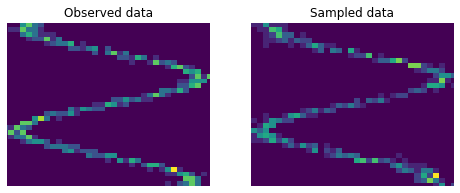

In [15]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plot_data(x[:,0].numpy(), y[:,0].numpy())
plt.title("Observed data")
plt.subplot(1, 2, 2)
plot_data(x[:,0].numpy(), samples[:,0].numpy())
plt.title("Sampled data")
plt.show()